https://colab.research.google.com/drive/1qS5CT7Rrl-540tawS8FKgadr5XDuCCr3?usp=sharing

# Ejemplo de aplicacion - Markowitz

## Repaso básico

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

df = yf.download(['PYPL','AAPL'], start='2010-01-01', end='2021-01-01')['Adj Close']
df = df.loc[~(df==0).any(axis=1)] 
retornos = np.log((df/df.shift(1)).dropna())

[*********************100%***********************]  2 of 2 completed


In [2]:
retornos

,AAPL,PYPL
Date,,
2015-07-07,-0.002463,-0.002455
2015-07-08,-0.025136,-0.053855
2015-07-09,-0.020607,-0.005780
2015-07-10,0.026383,0.005492
2015-07-13,0.019122,0.058503
...,...,...
2020-11-12,-0.002346,-0.016989
2020-11-13,0.000419,-0.002542
2020-11-16,0.008683,0.017448


In [3]:
datosTickers = []
for ticker in retornos.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 252
    d['volatilidad'] = retornos[ticker].std() * (252**0.5)
    d['sharpe'] = d['retorno'] / d['volatilidad']
    datosTickers.append(d)
    

datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
datosTickers

,retorno,volatilidad,sharpe
ticker,,,
AAPL,0.263022,0.302752,0.868769
PYPL,0.305860,0.342135,0.893975


In [4]:
pond = np.array(np.random.random(len(df.columns)))
pond = pond/np.sum(pond)
pond

array([0.82317849, 0.17682151])

In [47]:
q = 5000
retornos = np.log((df/df.shift(1)).dropna())
carteras = [] 

for i in range(q):
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}
    r['retorno'] = np.sum( (retornos.mean() * pond * 252))
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*252, pond)))
    r['sharpe'] = r['retorno'] / r['volatilidad'] 
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
carteras

,retorno,volatilidad,sharpe,pesos
0,0.272005,0.287820,0.945050,"[0.7903, 0.2097]"
1,0.271637,0.288191,0.942557,"[0.7989, 0.2011]"
2,0.299320,0.319591,0.936574,"[0.1527, 0.8473]"
3,0.283333,0.287090,0.986913,"[0.5259, 0.4741]"
4,0.283179,0.286961,0.986822,"[0.5295, 0.4705]"
...,...,...,...,...
4995,0.288065,0.292882,0.983554,"[0.4154, 0.5846]"
4996,0.286424,0.290481,0.986034,"[0.4537, 0.5463]"
4997,0.277010,0.284927,0.972216,"[0.6735, 0.3265]"
4998,0.288392,0.293408,0.982901,"[0.4078, 0.5922]"


In [48]:
carteras['sharpe'].max()

0.9871897101170718

In [49]:
carteras['sharpe'].idxmax()

3583

In [50]:
carteras.loc[ carteras['sharpe'].idxmax(), 'pesos']

array([0.5023, 0.4977])

In [51]:
optimo = carteras.loc[carteras['sharpe'].idxmax()]
mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
AAPL,0.263022,0.302752,0.868769,0.5023
PYPL,0.305860,0.342135,0.893975,0.4977


In [52]:
optimo

retorno                0.284343
volatilidad            0.288033
sharpe                  0.98719
pesos          [0.5023, 0.4977]
Name: 3583, dtype: object

In [53]:
mejor_port

array([0.5023, 0.4977])

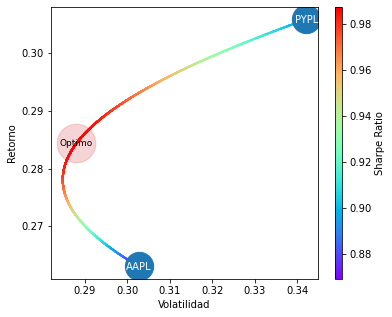

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(carteras.volatilidad, carteras.retorno, c=carteras.sharpe, s=1, cmap='rainbow')

plt.colorbar(label='Sharpe Ratio', aspect=40)
plt.xlabel('Volatilidad')
plt.ylabel('Retorno')

plt.scatter(optimo.volatilidad, optimo.retorno,c='tab:red', alpha=0.2, s=1500) 
plt.text(optimo.volatilidad, optimo.retorno, 'Optimo', fontsize=9, c='k', ha='center', va='center') 

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad'] 
    ret = datosTickers.loc[ticker,'retorno'] 
    plt.scatter(vol, ret,  c='tab:blue', s=800) 
    plt.text(vol, ret, ticker, c='w', ha='center', va='center') 

## Markowitz - 500 activos

Buscamos el portafolio optimo entre muchos portafolios posibles

### Bajamos Data

In [14]:
import yfinance as yf, numpy as np, pandas as pd, random, tqdm


# Obtengo el listado de tickers del sp500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e for e in sp500_tickers if e not in ('BRK.B','BF.B')]

sp500_tickers[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

In [15]:
sp500

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [16]:
len(sp500_tickers)

503

In [17]:
import yfinance as yf, numpy as np, pandas as pd, random, tqdm
pd.options.display.max_columns = 8

In [20]:
conteo = pd.DataFrame(data_sp500.count(), columns=['Q'])
conteo

,Q
A,727
AAL,727
AAP,727
AAPL,727
ABBV,727
...,...
YUM,727
ZBH,727
ZBRA,727
ZION,727


In [18]:
%%time

# Obtengo todos los historicos
data_sp500 = yf.download(sp500_tickers, start='2018-01-01', end='2021-01-01')['Adj Close']

# Para evitar tickers con poco historial
conteo = pd.DataFrame(data_sp500.count(), columns=['Q'])
sp500_tickers = list(conteo.loc[conteo.Q>500].index)

data_sp500

[*********************100%***********************]  503 of 503 completed
Wall time: 43.2 s


,A,AAL,AAP,AAPL,...,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,
2018-01-02,65.985886,51.647556,104.916702,41.105534,...,121.328224,103.709999,46.599628,70.489136
2018-01-03,67.664825,51.014027,105.866096,41.098373,...,122.169281,105.769997,46.544483,70.813225
2018-01-04,67.157242,51.335667,109.772415,41.289268,...,121.993256,107.860001,46.737503,71.235565
2018-01-05,68.230972,51.316177,110.939346,41.759361,...,123.205963,109.540001,46.755882,72.050766
2018-01-08,68.377396,50.809345,110.158089,41.604263,...,123.440674,110.629997,46.526104,72.915047
...,...,...,...,...,...,...,...,...,...
2020-11-12,109.440002,11.740000,153.059998,119.209999,...,148.429993,340.779999,36.330002,165.190002
2020-11-13,110.169998,12.240000,154.000000,119.260002,...,151.360001,345.859985,37.480000,165.779999
2020-11-16,110.269997,12.790000,151.059998,120.300003,...,150.220001,345.980011,39.750000,165.289993


In [21]:
len(sp500_tickers)

494

### Dirichlet vs Uniform

Muestra de ponderaciones que sumen 1, con restricciones (min y max)

https://en.wikipedia.org/wiki/Dirichlet_distribution

In [22]:
np.random.dirichlet(np.ones(5),1)

array([[0.25388254, 0.17689261, 0.159157  , 0.20394786, 0.20611998]])

In [26]:
np.random.dirichlet([1,1,1,1,1],1)

array([[0.03115753, 0.28191032, 0.39699949, 0.12385289, 0.16607977]])

In [30]:
np.random.dirichlet([500]*5,1)

array([[0.19490003, 0.21745978, 0.1757996 , 0.20579956, 0.20604103]])

In [29]:
np.random.dirichlet([0.3]*5,1)*100

array([[5.66490492e-02, 7.24599712e+01, 1.82074272e-01, 6.66276064e-05,
        2.73012389e+01]])

In [33]:
np.random.dirichlet([1,1,1,1,10],10)

array([[0.09421992, 0.10271612, 0.07333765, 0.01149643, 0.71822989],
       [0.09623705, 0.1344124 , 0.01271221, 0.05754686, 0.69909149],
       [0.15726993, 0.01084631, 0.00719012, 0.02668638, 0.79800726],
       [0.03832177, 0.01651789, 0.04520269, 0.03698965, 0.862968  ],
       [0.03434693, 0.20144206, 0.00371837, 0.18969311, 0.57079953],
       [0.12618863, 0.05707255, 0.0179363 , 0.00853732, 0.7902652 ],
       [0.0686251 , 0.11092275, 0.08156652, 0.02235572, 0.71652991],
       [0.06587713, 0.12574458, 0.005519  , 0.17395   , 0.62890929],
       [0.12652262, 0.01976202, 0.16127541, 0.17097399, 0.52146597],
       [0.05428435, 0.15402356, 0.02820198, 0.04509152, 0.71839858]])

In [41]:
np.random.dirichlet([5,5,5,5,50],10)

array([[0.04952857, 0.05698236, 0.04451952, 0.12241644, 0.72655311],
       [0.0616004 , 0.09957818, 0.11379036, 0.04143569, 0.68359537],
       [0.04421705, 0.03906719, 0.04305727, 0.0899643 , 0.78369418],
       [0.06625455, 0.06624793, 0.07471602, 0.0486038 , 0.7441777 ],
       [0.02326149, 0.06868708, 0.10803187, 0.0624318 , 0.73758776],
       [0.09675046, 0.08094066, 0.07287113, 0.08724872, 0.66218903],
       [0.19463781, 0.06904282, 0.08257872, 0.07609324, 0.57764741],
       [0.04010813, 0.10469147, 0.02732955, 0.04627437, 0.78159648],
       [0.10129838, 0.05078344, 0.08157124, 0.05319221, 0.71315472],
       [0.02882856, 0.09560211, 0.07314945, 0.04844954, 0.75397033]])

In [38]:
x = 1
np.random.dirichlet([x]*5,10000).std()

0.16278865966324904

In [39]:
x = 3
np.random.dirichlet([x]*5,10000).std()

0.09957172645979333

In [40]:
x = 0.5
np.random.dirichlet([x]*5,10000).std()

0.2139091160402634

In [43]:
p_min, p_max = 0.05, 0.5
n_stocks = 5

ponds = np.random.dirichlet(np.ones(n_stocks),100)
oks = [p for p in ponds if (p.min()>p_min) & (p.max()<p_max)]
oks[0]

array([0.05881888, 0.09676947, 0.18119684, 0.19358646, 0.46962835])

In [45]:
media = (p_min+p_max)/2

pond = np.random.uniform(p_min*media*n_stocks, p_max*media*n_stocks, n_stocks)
pond = pond / np.sum(pond)
pond.round(4)

array([0.1453, 0.3416, 0.2487, 0.1886, 0.0757])

In [46]:
500*499*498/6

20708500.0

### Funcion optimizadora

In [59]:
random.sample(sp500_tickers, 3)

['AFL', 'LDOS', 'HFC']

In [60]:
import sys

def simular(data, tickers, q, n_stocks=3, p_min=0.1, p_max=0.6):
    
    datos = []
    with tqdm.tqdm(total=q, file=sys.stdout) as pbar:
        for i in range(q):
            pbar.update()

            muestra = data[random.sample(tickers, n_stocks)]
                        
            # Restriccion de minimo
            ponds = np.random.dirichlet(np.ones(n_stocks),50)
            pond = np.array([p for p in ponds if (p.min()>p_min) & (p.max()<p_max)][0])
            
            # If para evitar activos sin dataFeed
            if len(retornos):    
                r={}
                r['activos'] = list(muestra.columns)
                r['pesos'] = pond.round(3)
                r['retorno'] = np.sum( (muestra.mean() * pond * 252))
                r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(muestra.cov()*252, pond)))
                r['sharpe'] = round(r['retorno'] / r['volatilidad'],3) 
                datos.append(r)
    
    df = pd.DataFrame(datos).sort_values('sharpe', ascending=False)

    return df

In [61]:
pd.options.display.width = 1000

ret_log = np.log(data_sp500/data_sp500.shift(1))

portfolios = simular(ret_log, sp500_tickers, 20000,3)
print('\n',portfolios.head(10))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:40<00:00, 493.52it/s]

                   activos                  pesos   retorno  volatilidad  sharpe
5698      [TGT, CMG, BLL]  [0.397, 0.363, 0.241]  0.401698     0.257758   1.558
11683    [AMD, CMG, ODFL]  [0.417, 0.264, 0.319]  0.520885     0.367951   1.416
2844     [CMG, DXCM, ARE]  [0.379, 0.419, 0.201]  0.469673     0.332539   1.412
4971     [MSCI, CMG, MKC]  [0.306, 0.566, 0.128]  0.444960     0.316611   1.405
19540     [AWK, CMG, CLX]  [0.194, 0.572, 0.234]  0.370985     0.267315   1.388
5930      [BLL, AMD, KMB]   [0.576, 0.29, 0.135]  0.402820     0.297479   1.354
16011     [CMG, NKE, NOW]  [0.244, 0.339, 0.417]  0.410321     0.303611   1.351
2372      [CMG, AES, BIO]  [0.587, 0.209, 0.205]  0.421589     0.312180   1.350
15911  [DXCM, VRSK, IDXX]   [0.23, 0.341, 0.429]  0.383473     0.286844   1.337
7229    [CDNS, DXCM, TGT]  [0.302, 0.123, 0.575]  0.373066     0.279457   1.33

In [62]:
portfolios

,activos,pesos,retorno,volatilidad,sharpe
5698,"[TGT, CMG, BLL]","[0.397, 0.363, 0.241]",0.401698,0.257758,1.558
11683,"[AMD, CMG, ODFL]","[0.417, 0.264, 0.319]",0.520885,0.367951,1.416
2844,"[CMG, DXCM, ARE]","[0.379, 0.419, 0.201]",0.469673,0.332539,1.412
4971,"[MSCI, CMG, MKC]","[0.306, 0.566, 0.128]",0.444960,0.316611,1.405
19540,"[AWK, CMG, CLX]","[0.194, 0.572, 0.234]",0.370985,0.267315,1.388
...,...,...,...,...,...
11542,"[AAL, T, VTRS]","[0.512, 0.268, 0.22]",-0.334182,0.422739,-0.791
10379,"[KHC, APA, NLSN]","[0.525, 0.142, 0.333]",-0.281922,0.356438,-0.791
11929,"[KHC, SWK, AAL]","[0.414, 0.12, 0.466]",-0.328676,0.413974,-0.794
13919,"[DHI, AAL, OXY]","[0.168, 0.362, 0.469]",-0.413870,0.516594,-0.801


In [68]:
top = portfolios.iloc[ : 100]

top.activos.apply(pd.Series).stack().reset_index(drop=True)

0       TGT
1       CMG
2       BLL
3       AMD
4       CMG
       ... 
295    COST
296    INTU
297     MAA
298      DG
299    KEYS
Length: 300, dtype: object

In [69]:
top = portfolios.iloc[ : 100]
lista_tickers = list(top.activos.apply(pd.Series).stack())
len(lista_tickers)

300

In [70]:
np.unique(lista_tickers, return_counts=True)

(array(['AAPL', 'ABC', 'ADBE', 'ADSK', 'AEE', 'AES', 'AIZ', 'AJG', 'ALLE',
        'AMD', 'ANSS', 'AON', 'APD', 'ARE', 'AVY', 'AWK', 'AZO', 'BBY',
        'BIO', 'BLL', 'BMY', 'BSX', 'CAT', 'CDNS', 'CDW', 'CHD', 'CLX',
        'CME', 'CMG', 'CMI', 'CMS', 'COST', 'CPB', 'CPRT', 'CSCO', 'CTAS',
        'CTLT', 'CTXS', 'DG', 'DHR', 'DPZ', 'DVA', 'DXCM', 'EMN', 'EMR',
        'EQIX', 'ETN', 'ETSY', 'EW', 'EXR', 'FAST', 'GOOG', 'GWW', 'HBAN',
        'HCA', 'HSY', 'IDXX', 'INFO', 'INTU', 'ITW', 'JKHY', 'JPM', 'KEYS',
        'KIM', 'KMB', 'KMX', 'LDOS', 'LIN', 'LLY', 'LMT', 'LW', 'LYV',
        'MA', 'MAA', 'MCO', 'MDLZ', 'MKC', 'MKTX', 'MMC', 'MRK', 'MSCI',
        'MSFT', 'MSI', 'MTB', 'MTD', 'NEE', 'NEM', 'NFLX', 'NKE', 'NLOK',
        'NOW', 'NSC', 'O', 'ODFL', 'ORCL', 'PAYC', 'PCAR', 'PGR', 'PLD',
        'POOL', 'PSA', 'PYPL', 'RMD', 'ROL', 'ROP', 'RSG', 'SBUX', 'SEE',
        'SHW', 'SNPS', 'SPGI', 'STE', 'TDY', 'TER', 'TGT', 'TJX', 'TMO',
        'TT', 'TXT', 'TYL', 'UAA', 'UNH', 'V

In [72]:
freq = pd.DataFrame(np.unique(lista_tickers, return_counts=True)).T
freq.columns=['Ticker','Frecuencia']
freq.sort_values('Frecuencia', ascending=False).head(10)

,Ticker,Frecuencia
28,CMG,22
42,DXCM,21
9,AMD,16
114,TGT,11
127,WST,9
31,COST,8
39,DHR,7
95,PAYC,7
47,ETSY,6
38,DG,6


## Markowitz - Optimizacion de suboptimo

Optimmizamos las iteraciones para encontrar un sub-optimo mas rapido

In [73]:
%%time
q_inicial = 400
lista_tickers = sp500_tickers
ret_log = np.log(data_sp500/data_sp500.shift(1))

portfolios = simular(ret_log, lista_tickers, q_inicial, n_stocks=6, p_min=0.01, p_max=0.99)

best = pd.DataFrame()
for i in range(8):
    qsim = int(q_inicial/(i+2))
    qtop = qsim // 3
    
    top = portfolios.iloc[ : qtop]
    lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
    portfolios = simular(ret_log, lista_tickers, qsim)
    best = pd.concat([best,portfolios.iloc[:10]])

print('Mejores\n',best.sort_values('sharpe', ascending=False).head(10))

100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 450.45it/s]
Mejores
              activos                  pesos   retorno  volatilidad  sharpe
3   [DXCM, WST, CMG]  [0.213, 0.378, 0.409]  0.477649     0.293530   1.627
54  [CMG, WST, DXCM]  [0.293, 0.442, 0.265]  0.472566     0.291402   1.622
23   [CMG, TGT, WST]  [0.409, 0.223, 0.368]  0.422019     0.260512   1.620
6   [TGT, CMG, DXCM]  [0.348, 0.349, 0.303]  0.482102     0.297635   1.620
28  [WST, DXCM, CMG]  [0.389, 0.167, 0.443]  0.472028     0.291514   1.619
33   [WST, CMG, TGT]    [0.3, 0.353, 0.347]  0.410761     0.253964   1.617
38   [WST, CMG, TGT]   [0.312, 0.33, 0.358]  0.407048     0.251749   1.617
23  [WST, DXCM, CMG]  [0.525, 0.134, 0.341]  0.448608     0.277703   1.615
26  [TGT, DXCM, CMG]  [0.353, 0.349, 0.298]  0.485079     0.301994   1.606
34   [CMG, WST, TGT]  [0.277, 0.529, 0.194]  0.402801     0.251355   1.603
Wall time: 2.73 s


## Rolling trimestral del proceso

### Bajamos Data mas antigua

In [74]:
pd.options.display.max_columns = 6

In [75]:
%%time

data_sp500 = yf.download(sp500_tickers, start='2000-01-01', end='2021-01-01')['Adj Close']
data_sp500.to_csv('nombre_archivo.csv')

[*********************100%***********************]  494 of 494 completed
Wall time: 1min 4s


,A,AAL,AAP,...,ZBRA,ZION,ZTS
Date,,,,,,,
2000-01-03,44.603386,NaN,NaN,...,25.027779,39.996193,NaN
2000-01-04,41.196171,NaN,NaN,...,24.666666,38.059437,NaN
2000-01-05,38.640766,NaN,NaN,...,25.138889,38.014412,NaN
2000-01-06,37.169479,NaN,NaN,...,23.777779,38.554890,NaN
2000-01-07,40.266937,NaN,NaN,...,23.513889,38.644981,NaN
...,...,...,...,...,...,...,...
2020-11-12,109.440002,11.74,153.059998,...,340.779999,36.330002,165.190002
2020-11-13,110.169998,12.24,154.000000,...,345.859985,37.480000,165.779999
2020-11-16,110.269997,12.79,151.059998,...,345.980011,39.750000,165.289993


In [76]:
data_sp500.to_csv('nombre_archivo.csv')

### Guardamos la data 

In [77]:
import pickle

In [78]:
with open('data/portafolio/yahoo_sp500_10yr.dat', 'wb') as file:
    pickle.dump(data_sp500, file)

In [81]:
%%timeit

with open('data/portafolio/yahoo_sp500_10yr.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

13.8 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
pd.options.display.max_columns = 6
data_sp500

,A,AAL,AAP,...,ZBRA,ZION,ZTS
Date,,,,,,,
2000-01-03,44.603386,NaN,NaN,...,25.027779,39.996193,NaN
2000-01-04,41.196171,NaN,NaN,...,24.666666,38.059437,NaN
2000-01-05,38.640766,NaN,NaN,...,25.138889,38.014412,NaN
2000-01-06,37.169479,NaN,NaN,...,23.777779,38.554890,NaN
2000-01-07,40.266937,NaN,NaN,...,23.513889,38.644981,NaN
...,...,...,...,...,...,...,...
2020-11-12,109.440002,11.74,153.059998,...,340.779999,36.330002,165.190002
2020-11-13,110.169998,12.24,154.000000,...,345.859985,37.480000,165.779999
2020-11-16,110.269997,12.79,151.059998,...,345.980011,39.750000,165.289993


### Fragmentamos la data

In [85]:
trimestres = pd.date_range(start='1/1/2000', end='31/12/2020', freq='Q')
trimestres

DatetimeIndex(['2000-03-31', '2000-06-30', '2000-09-30', '2000-12-31', '2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31', '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31', '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31', '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31', '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31', '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31', '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31', '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30',
     

In [86]:
trimestres_from = list(trimestres[:-1])
trimestres_to = list(trimestres[1:])

In [87]:
dfs = []
rets_log = np.log(data_sp500/data_sp500.shift(1))
for i in range (len(trimestres_from)):
    df = rets_log.loc[(rets_log.index >= trimestres_from[i]) & (rets_log.index <= trimestres_to[i])].copy()
    df.dropna(axis=1, thresh=30, inplace=True)
    dfs.append(df)

In [88]:
len(dfs)

83

In [90]:
dfs[1]

,A,AAPL,ABC,...,YUM,ZBRA,ZION
Date,,,,,,,
2000-06-30,-0.028406,0.021714,-0.003520,...,0.049896,-0.014006,-0.009151
2000-07-03,-0.000848,0.017742,-0.016764,...,0.013188,-0.024270,0.034469
2000-07-05,-0.047773,-0.032165,0.004090,...,0.015168,0.011494,-0.009253
2000-07-06,-0.016144,0.003625,0.102704,...,0.023381,0.044700,-0.006662
2000-07-07,-0.023789,0.049422,0.021859,...,0.072907,0.024293,0.013281
...,...,...,...,...,...,...,...
2000-09-25,-0.034333,0.024839,0.071306,...,0.019130,-0.013870,0.023433
2000-09-26,-0.066870,-0.039314,0.004806,...,0.000000,0.030264,0.027878
2000-09-27,0.017821,-0.049823,-0.032014,...,-0.016986,-0.041500,0.046911


### Encapsulamos implementacion para optimizar

In [91]:
def top10(ret_log, lista_tickers, q_inicial=1000, rondas=10, n_inicial=6):
    portfolios = simular(ret_log, lista_tickers, q_inicial, n_stocks=n_inicial, p_min=0.01, p_max=0.99)
    best = pd.DataFrame()
    for i in range(rondas):
        qsim = int(q_inicial/(i+2))
        qtop = qsim//3

        top = portfolios.iloc[ : qtop]
        lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
        portfolios = simular(ret_log, lista_tickers, qsim)
        best = pd.concat([best,portfolios.iloc[:10]])

    top10 = best.sort_values('sharpe', ascending=False).head(10)
    return top10

### Corremos optimizacion rollenado trimestralmente

In [92]:
from IPython.display import clear_output

In [93]:
%%time

tops = []
for i, df in enumerate(dfs):
    clear_output(wait=True)
    print('Proceso N°',i+1,'de',len(dfs))
    print('Desde',trimestres_from[i],'Hasta',trimestres_to[i],'\n')
    top = top10(df, list(df.columns), q_inicial=500, rondas=5)
    tops.append(top.iloc[:10]) 


Proceso N° 83 de 83
Desde 2020-09-30 00:00:00 Hasta 2020-12-31 00:00:00 

100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 438.13it/s]
Wall time: 3min 50s


In [94]:
activos, pesos = [], []
for i in range(10):
    activos.append([df.iloc[i].activos for df in tops])
    pesos.append([df.iloc[i].pesos for df in tops])

In [99]:
resumen = pd.DataFrame()

for top_nro in range(10):
    lista_rendimientos = []
    for i in range(1,len(dfs)):
        filtro_fecha = data_sp500.loc[(data_sp500.index >= trimestres_from[i]) & (data_sp500.index <= trimestres_to[i])]
        filtro_activos = filtro_fecha[activos[top_nro][i-1]].dropna()
        r = filtro_activos.pct_change()
        w = pesos[top_nro][i-1]
        fechas = pd.to_datetime(filtro_activos.index)
        lista_rendimientos.append(pd.Series(np.dot(r, w), index=fechas).dropna())

    rendimientos = pd.concat(lista_rendimientos)
    resumen['Test_'+str(top_nro)] = (rendimientos+1).cumprod()

resumen

,Test_0,Test_1,Test_2,...,Test_7,Test_8,Test_9
Date,,,,,,,
2000-07-03,1.001647,1.012209,1.013864,...,1.003401,1.004447,0.998563
2000-07-05,0.995213,1.012852,1.021234,...,1.008487,0.997105,1.004534
2000-07-06,0.985695,1.038980,1.023834,...,1.004145,1.024788,1.029754
2000-07-07,0.987992,1.048567,1.025560,...,0.998239,1.032188,1.030463
2000-07-10,1.003650,1.046253,1.024923,...,1.002389,1.035389,1.036883
...,...,...,...,...,...,...,...
2020-11-12,58.564540,27.930520,33.779070,...,32.573721,46.967956,48.916038
2020-11-13,59.509171,28.313356,34.316029,...,33.060165,47.721363,49.724161
2020-11-16,60.572101,29.136676,35.026193,...,33.735139,49.108247,51.168728


### Guardamos resultados estrategia

In [100]:
with open('data/portafolio/resumen.dat', 'wb') as file:
    pickle.dump(resumen, file)

with open('data/portafolio/resumen.dat', 'rb') as file:
    resumen = pickle.load(file)

### Ploteamos

<AxesSubplot:xlabel='Date'>

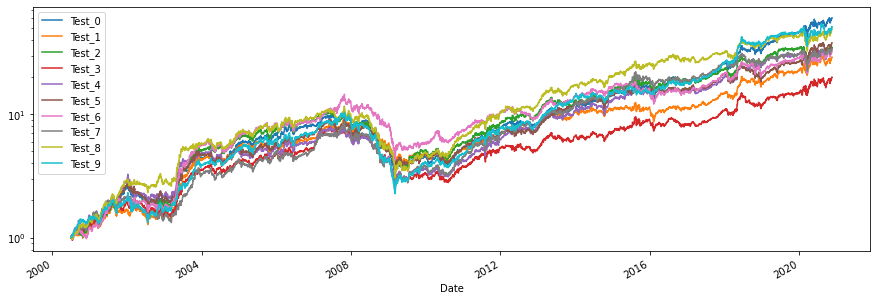

In [101]:
resumen.plot(figsize=(15,5), logy=True)

In [102]:
inicio = list(resumen.index)[0].isoformat()[:10]
inicio

'2000-07-03'

In [103]:
spy = yf.download('SPY', start=inicio, auto_adjust=True)
spy['pctChange'] = spy.Close.pct_change()
spy['rendimiento_acum'] = (spy.pctChange+1).cumprod()

[*********************100%***********************]  1 of 1 completed


[]

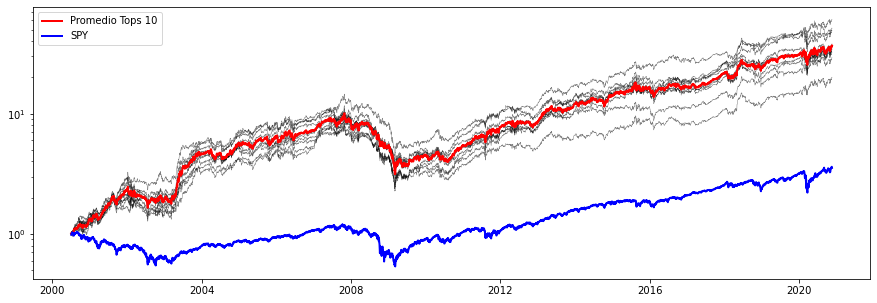

In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

for columna in resumen.columns:
    ax.plot(resumen[columna], 'k', alpha=0.5, lw=0.5)
    ax.set_yscale('log')

ax.plot(resumen.iloc[:,:-1].mean(axis=1), 'red', lw=2, label='Promedio Tops 10')
ax.plot(spy['rendimiento_acum'], 'blue', lw=2, label='SPY')

ax.legend()
ax.plot()

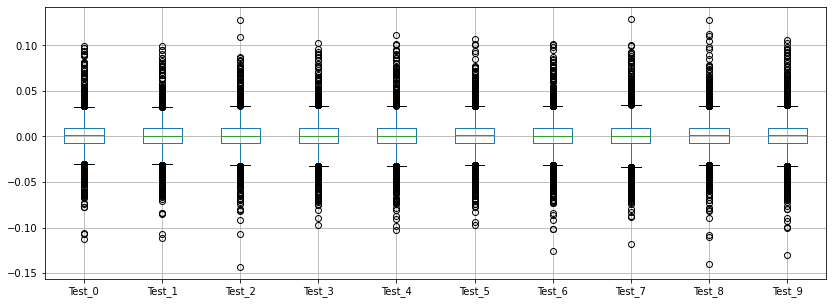

In [107]:
pd.plotting.boxplot_frame(resumen.pct_change(), figsize=(14,5))
plt.show()

## Reporting Final

In [108]:
estrategia = resumen.iloc[:,:-1].mean(axis=1)

# Armo estrategia mas conservadora
free_risk = pd.DataFrame(index=estrategia.index)
free_risk['usa'] = 0.0001
estrategia_5050 = estrategia.pct_change()*0.5 + free_risk['usa']*0.5

# Defino un benchMark
benchmark = spy['rendimiento_acum']

In [109]:
# !pip install QuantStats
import quantstats as qs
qs.extend_pandas()

In [110]:
qs.stats.outliers(estrategia.pct_change()-benchmark.pct_change(), quantile=0.995)

Date
2000-12-20    0.064163
2001-02-02    0.044159
2001-08-03    0.042173
2001-09-17    0.055802
2002-01-24    0.050229
2003-04-02    0.044541
2003-04-24    0.048784
2003-05-05    0.050494
2003-05-09    0.047712
2003-05-27    0.042874
2003-06-16    0.060077
2008-03-11    0.045741
2008-10-15    0.062223
2008-11-19    0.050129
2009-04-27    0.047557
2009-07-23    0.047922
2010-08-12    0.044063
2011-08-05    0.047109
2011-08-10    0.042143
2011-11-14    0.042823
2012-04-26    0.057329
2015-07-16    0.058379
2018-05-03    0.067410
2020-04-15    0.045825
2020-05-28    0.054217
2020-05-29    0.069025
dtype: float64

In [116]:
pd.options.display.max_columns=13
qs.stats.monthly_returns(estrategia)

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,EOY
2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063721,0.042848,0.077567,-0.041587,-0.005624,0.167388,0.295164
2001,0.020823,0.034512,-0.038749,0.079479,0.106377,0.107534,0.067984,0.004041,0.000253,0.050236,0.066598,0.083463,0.583017
2002,-0.053390,-0.075469,0.013152,0.000776,-0.020411,-0.021571,-0.057145,0.044576,-0.020667,-0.010019,0.074020,-0.084099,-0.184010
2003,0.046428,-0.028787,0.049232,0.206213,0.300843,0.141999,0.042899,0.009637,0.061094,0.098604,0.076289,-0.010357,0.964088
2004,0.007689,0.030369,0.034530,-0.132502,0.071522,0.013874,-0.077744,-0.006918,0.085902,0.030585,0.105350,0.072414,0.225265
2005,-0.029023,0.008895,-0.015342,-0.041376,0.034155,0.080775,0.045671,-0.013340,0.032857,-0.109525,0.050315,0.078610,0.125323
2006,-0.058910,0.064733,0.113677,-0.006135,-0.059838,0.006160,0.010000,0.026802,0.004134,0.006504,0.031900,0.004746,0.152514
2007,0.053502,0.057003,0.044091,0.018945,0.050357,-0.037698,-0.032476,0.007324,0.060544,0.061592,-0.080213,-0.024012,0.191243
2008,-0.099813,0.015655,0.025396,0.028116,0.015952,-0.049570,-0.111882,0.002256,-0.115506,-0.081396,-0.010625,-0.042945,-0.385064
2009,-0.179039,-0.186755,0.057605,0.035986,-0.063502,0.004280,0.098386,-0.015977,0.069317,-0.053842,0.050395,0.046087,-0.130913


In [117]:
127/87, 59/42

(1.4597701149425288, 1.4047619047619047)

In [48]:
qs.reports.metrics(estrategia, benchmark, mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-07-03  2000-07-03
End Period                 2020-11-18  2020-11-18
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          3,963.77%   264.54%
CAGR%                      19.92%      6.55%
Sharpe                     0.87        0.42
Sortino                    1.27        0.59
Max Drawdown               -73.21%     -55.19%
Longest DD Days            1928        2241
Volatility (ann.)          24.45%      19.8%
R^2                        0.39        0.39
Calmar                     0.27        0.12
Skew                       0.04        -0.03
Kurtosis                   4.52        12.77

Expected Daily %           0.07%       0.03%
Expected Monthly %         1.52%       0.53%
Expected Yearly %          19.29%      6.35%
Kelly Criterion            5.25%       -0.05%
Risk of Ruin               0.0%  

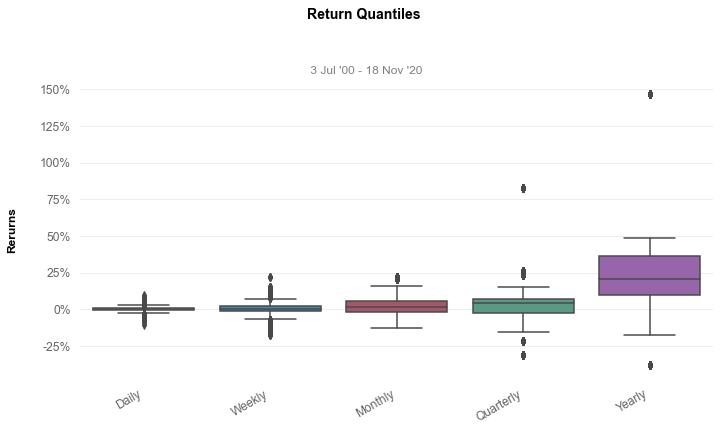

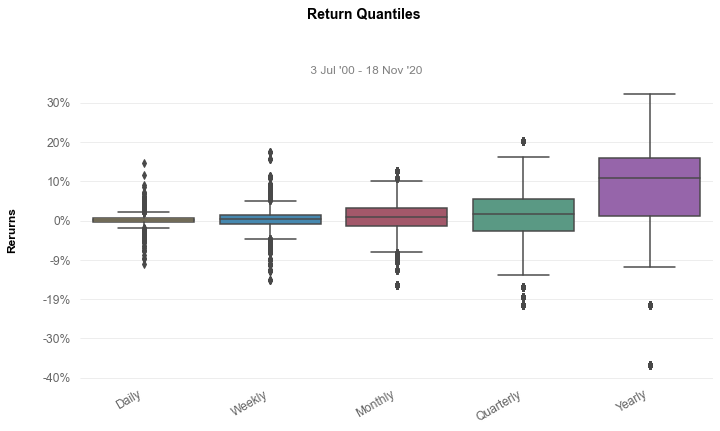

In [49]:
qs.plots.distribution(estrategia)
qs.plots.distribution(benchmark)

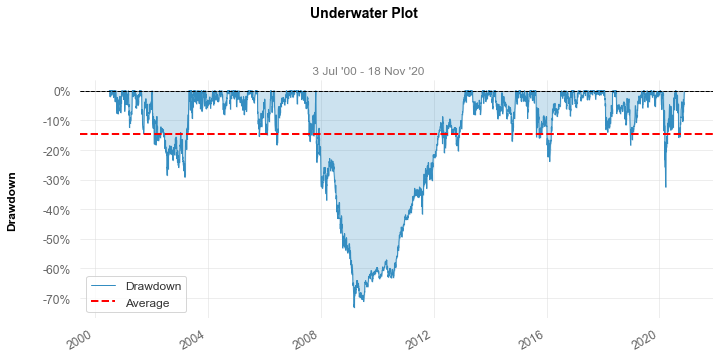

In [50]:
qs.plots.drawdown(estrategia)

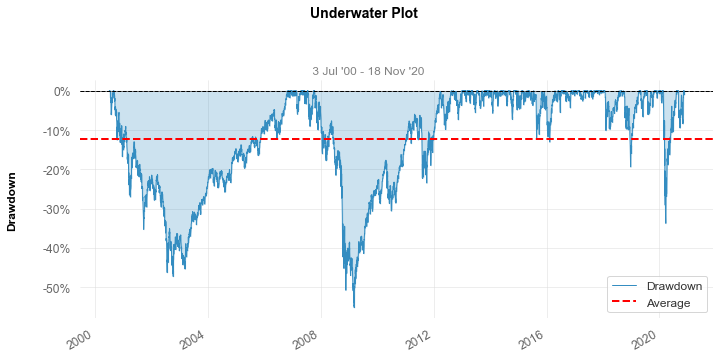

In [51]:
qs.plots.drawdown(benchmark)

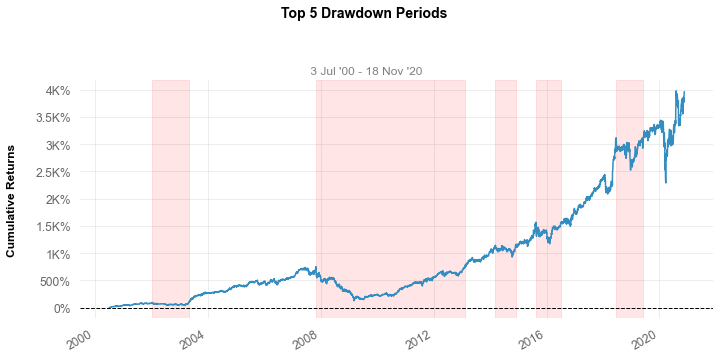

In [52]:
qs.plots.drawdowns_periods(estrategia)

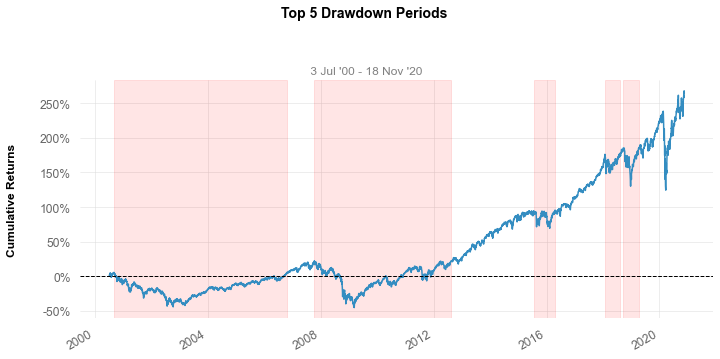

In [53]:
qs.plots.drawdowns_periods(benchmark)

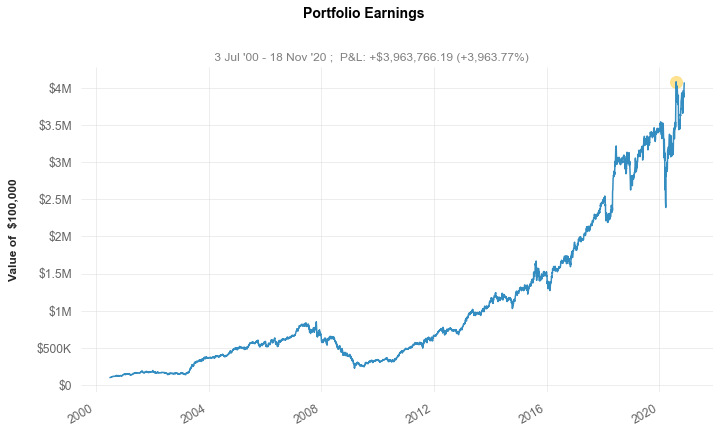

In [54]:
qs.plots.earnings(estrategia)

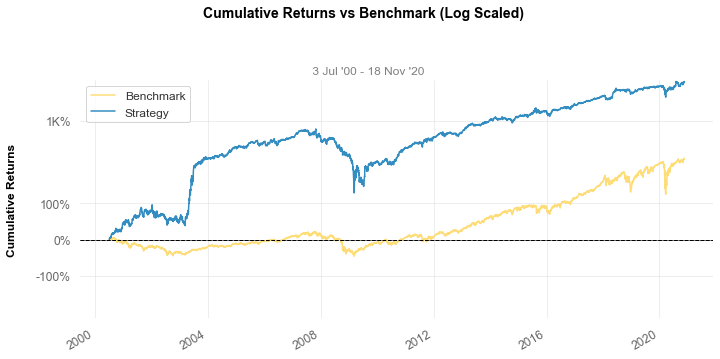

In [55]:
qs.plots.log_returns(estrategia, benchmark)

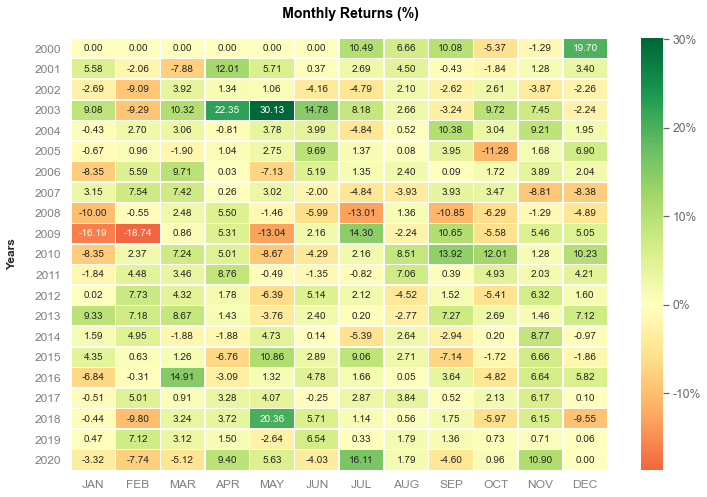

In [56]:
qs.plots.monthly_returns(estrategia, eoy=False)

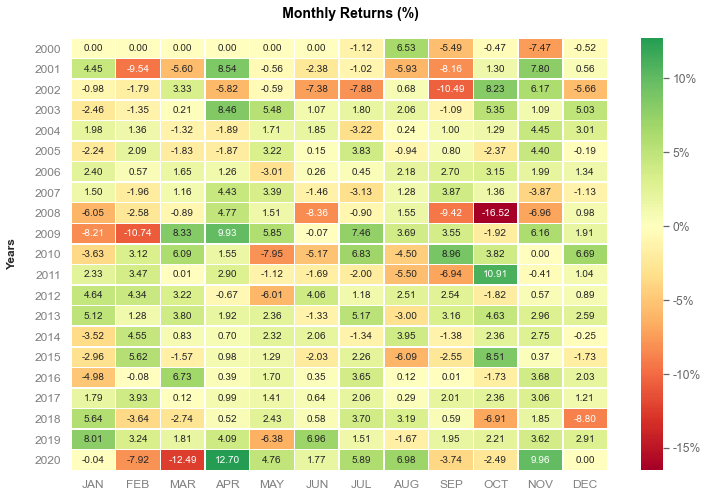

In [57]:
qs.plots.monthly_returns(benchmark, eoy=False)

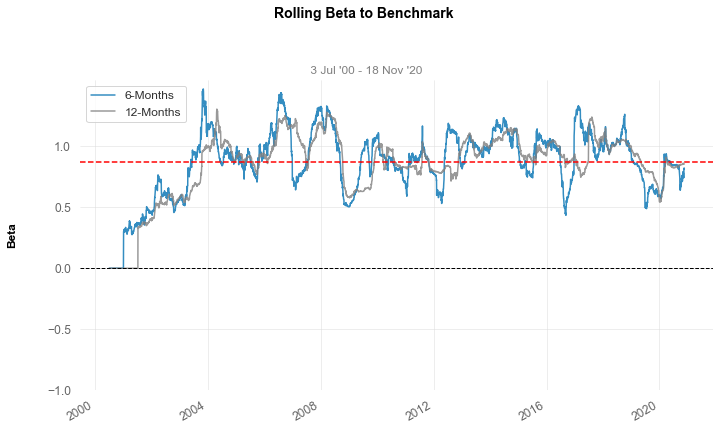

In [58]:
qs.plots.rolling_beta(estrategia, benchmark, figsize=(10,6))

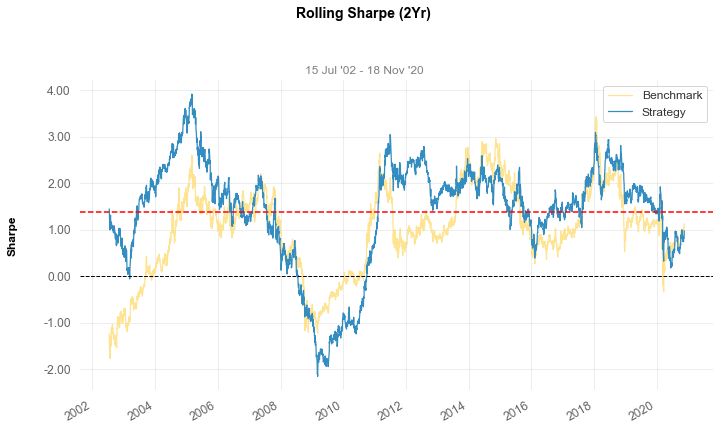

In [59]:
qs.plots.rolling_sharpe(estrategia, benchmark, figsize=(10,6), period=500, period_label='2Yr')

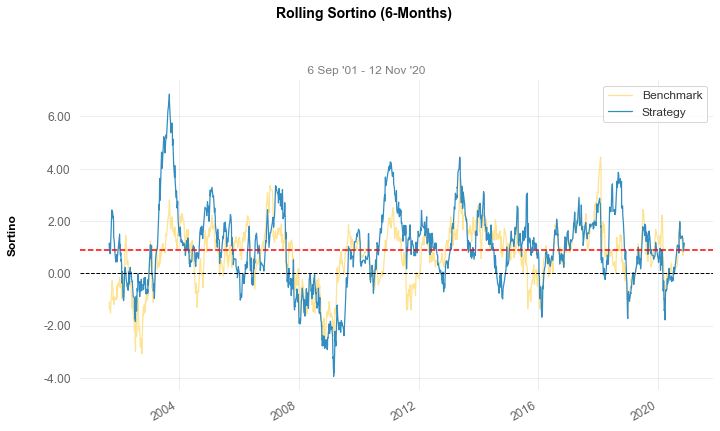

In [60]:
qs.plots.rolling_sortino(estrategia, benchmark, figsize=(10,6))

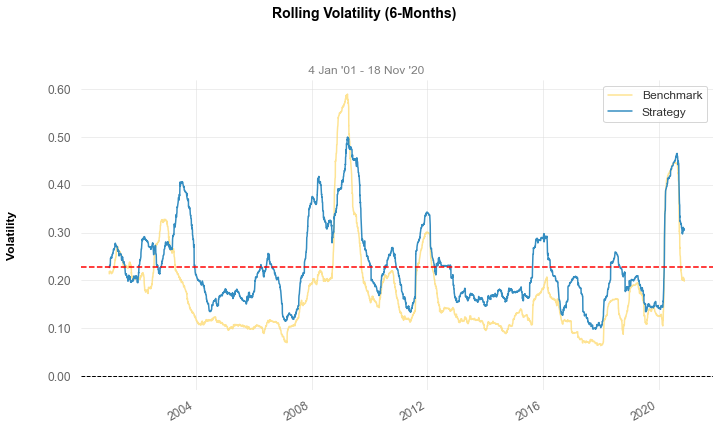

In [61]:
qs.plots.rolling_volatility(estrategia, benchmark, figsize=(10,6))

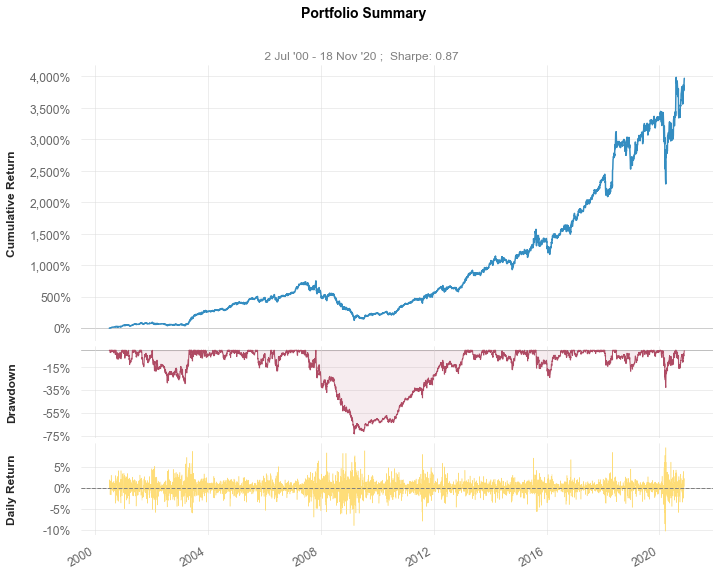

In [62]:
qs.plots.snapshot(estrategia)

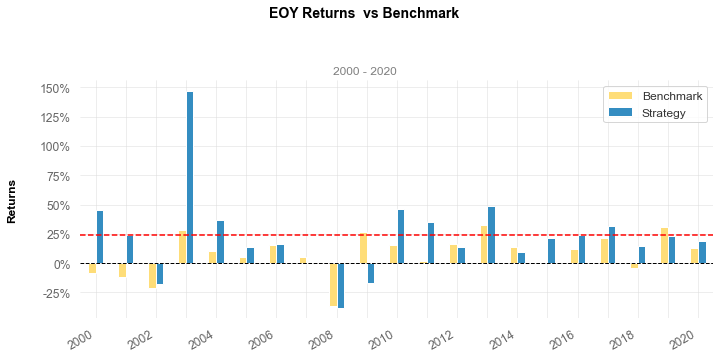

In [63]:
qs.plots.yearly_returns(estrategia, benchmark)